## Analysis of Customer Review Sentiment

### Introduction

This notebook uses Python programming language to build a machine learning model to identify the sentiment of customer reviews in a E-Commerce store for Women's Clothing. The information used is a real commercial and anoymised data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import string

from statistics import mean

#pip install -U textblob
from textblob import TextBlob

#pip install --user -U nltk
#import nltk
#nltk.download()
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer


#pip install -U scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB

#pip install --upgrade tensorflow
# pip install keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.embeddings import Embedding
from keras.layers import Flatten

In [2]:
# Open the dataset and create a Dataframe
df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')
df.shape

(23486, 11)

In [3]:
df = df.drop(['Unnamed: 0'], axis=1)
df = df.rename(columns = {'Clothing ID': 'Clothing_ID', 'Review Text': 'Review', 'Recommended IND': 'Recommended', 'Positive Feedback Count': 'Positive_feedback_count', 'Division Name': 'Division', 'Department Name': 'Department', 'Class Name': 'Class'})

### General Dataset Exploration

The dataset includes 23486 rows and 10 feature variables, with each row being one customer review. The reviews are for 1206 different clothes items which can be categorised into 3 divisions, 6 departments and 20 classes. All reviews have a associated clothes ID, however, some reviews are not categorised into a division, department or a class. 

The positive feedback count is a positive interger documenting the number of other customers who found this review positive.

The recommanded column is a binary value indicating whether the cusotmer recommends this product, with 1 being recommended and 0 being not recommended.

In [4]:
df.head()

,Clothing_ID,Age,Title,Review,Rating,Recommended,Positive_feedback_count,Division,Department,Class
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [5]:
print(pd.isnull(df.Clothing_ID).any(), pd.unique(df.Clothing_ID).shape)
print(pd.unique(df.Division), pd.unique(df.Division).shape)
print(pd.unique(df.Department), pd.unique(df.Department).shape)
print(pd.unique(df.Class), pd.unique(df.Class).shape)

False (1206,)
['Initmates' 'General' 'General Petite' nan] (4,)
['Intimate' 'Dresses' 'Bottoms' 'Tops' 'Jackets' 'Trend' nan] (7,)
['Intimates' 'Dresses' 'Pants' 'Blouses' 'Knits' 'Outerwear' 'Lounge'
 'Sweaters' 'Skirts' 'Fine gauge' 'Sleep' 'Jackets' 'Swim' 'Trend' 'Jeans'
 'Legwear' 'Shorts' 'Layering' 'Casual bottoms' nan 'Chemises'] (21,)


Every review has a valid rating, recommended and positive feedback count value. The distribution of the values in each category is graphed.

In [6]:
print(pd.isnull(df.Rating).any())
print(pd.isnull(df.Recommended).any())
print(pd.isnull(df.Positive_feedback_count).any())

False
False
False


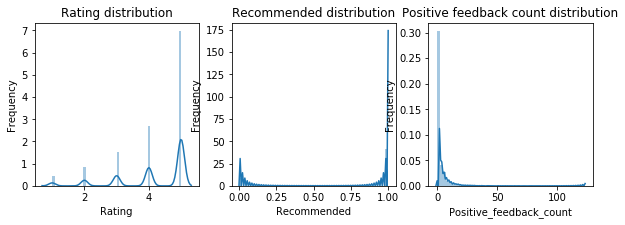

In [7]:
a, ax = plt.subplots(1, 3, figsize=(10, 3), sharey = False)


#Rating distribution
sns.distplot(df.Rating, ax=ax[0])
ax[0].set_title('Rating distribution')
ax[0].set_ylabel('Frequency')

#Recommended distribution
sns.distplot(df.Recommended, ax=ax[1])
ax[1].set_title('Recommended distribution')
ax[1].set_ylabel('Frequency')

#positive feedback count distribution
sns.distplot(df.Positive_feedback_count, ax=ax[2])
ax[2].set_title('Positive feedback count distribution')
ax[2].set_ylabel('Frequency')

plt.show()

For the purpose of this project, the machine learning model determines whether the customer would recommend the product based on their review. The model does not consider the categories of the clothes and the age of the reviewer.

In [8]:
# Extract useful information from the DataFrame

df_recommended = df.filter(['Title', 'Review', 'Recommended'], axis=1)
df_recommended = df_recommended.fillna("")

# combine title and review as both indicates customer sentiment

df_recommended['Combined_review'] = df_recommended.Title + " " + df_recommended.Review

In [9]:
df_recommended.head()

,Title,Review,Recommended,Combined_review
0,,Absolutely wonderful - silky and sexy and comf...,1,Absolutely wonderful - silky and sexy and com...
1,,Love this dress! it's sooo pretty. i happene...,1,Love this dress! it's sooo pretty. i happen...
2,Some major design flaws,I had such high hopes for this dress and reall...,0,Some major design flaws I had such high hopes ...
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",1,"My favorite buy! I love, love, love this jumps..."
4,Flattering shirt,This shirt is very flattering to all due to th...,1,Flattering shirt This shirt is very flattering...


The sentiment of the reviews are analysed with the sentiment property of TextBlob. A polarity of 1 suggests a positive statement and a polarity of -1 suggests a negative statement.

In [10]:
def polarity(text):
    text_textblob = TextBlob(text)
    return text_textblob.sentiment.polarity



df_recommended['Polarity'] = df_recommended['Combined_review'].apply(polarity)
df_recommended.head()



,Title,Review,Recommended,Combined_review,Polarity
0,,Absolutely wonderful - silky and sexy and comf...,1,Absolutely wonderful - silky and sexy and com...,0.633333
1,,Love this dress! it's sooo pretty. i happene...,1,Love this dress! it's sooo pretty. i happen...,0.339583
2,Some major design flaws,I had such high hopes for this dress and reall...,0,Some major design flaws I had such high hopes ...,0.073209
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",1,"My favorite buy! I love, love, love this jumps...",0.560714
4,Flattering shirt,This shirt is very flattering to all due to th...,1,Flattering shirt This shirt is very flattering...,0.512891


The reviews contain a mixed sentiments, with the large majority being positive reviews, followed by negative reviews, then finally the neutrual reviews. Using this dataset as t  may affect the machine learning model.

In [11]:
print('Number of positive reviews:', df_recommended[(df_recommended.Polarity > 0)].count()['Polarity'])
print('Number of neutrual reviews:', df_recommended[(df_recommended.Polarity == 0)].count()['Polarity'])
print('Number of negative reviews:', df_recommended[(df_recommended.Polarity < 0)].count()['Polarity'])



Number of positive reviews: 21408
Number of neutrual reviews: 897
Number of negative reviews: 1181


### Data Preprocessing

Each review is firstly cleaned by removing punctuations, white spaces, special characters. Commonly used words that does not provide value to sentiment analysis (e.g. 'the', 'a', 'is') is removed. Then lemmatisation is performed to normalise the words with the context of vocabulary and morphological analysis of the text.

In [12]:
def lemmatise(list_words):
    lemmatiser = WordNetLemmatizer()
    lemmatised_words = []
    for word, tag in pos_tag(list_words):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatised_words.append(lemmatiser.lemmatize(word, pos))
    return lemmatised_words

In [13]:
def clean_punctuation(word): #removing punctuations
    clean_word = ''
    for char in word:
        if char in string.punctuation:
            new_char = ''
        else:
            new_char = char
        clean_word += new_char
    return clean_word

In [14]:
def remove_nums(word): #removing numbers
    clean_word = ''
    for char in word:
        if char in '0123456789':
            new_char = ''
        else:
            new_char = char
        clean_word += new_char
    return clean_word

In [15]:
def check_empty(word_list):
    return list(filter(lambda x: x != '', word_list))

In [16]:
def text_processing(text):
    
    #separate text into words, removing white spaces and special characters
    tokenised = TextBlob(text.lower()).words 
    
    clean_punc = []
    for word in tokenised:
        no_num = remove_nums(word)
        clean_word = clean_punctuation(no_num)
        clean_punc.append(clean_word)
    
    clean_punc = check_empty(clean_punc)
    
    #remove stop words
    removed_stopwords = [word for word in clean_punc if word not in stopwords.words('english')]
    
    lemmatised_words = lemmatise(removed_stopwords)
    
    return " ".join(lemmatised_words)

In [17]:
df_recommended['Processed_text'] = df_recommended.Combined_review.apply(text_processing)
df_recommended.head()

,Title,Review,Recommended,Combined_review,Polarity,Processed_text
0,,Absolutely wonderful - silky and sexy and comf...,1,Absolutely wonderful - silky and sexy and com...,0.633333,absolutely wonderful silky sexy comfortable
1,,Love this dress! it's sooo pretty. i happene...,1,Love this dress! it's sooo pretty. i happen...,0.339583,love dress sooo pretty happen find store glad ...
2,Some major design flaws,I had such high hopes for this dress and reall...,0,Some major design flaws I had such high hopes ...,0.073209,major design flaws high hope dress really want...
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",1,"My favorite buy! I love, love, love this jumps...",0.560714,favorite buy love love love jumpsuit fun flirt...
4,Flattering shirt,This shirt is very flattering to all due to th...,1,Flattering shirt This shirt is very flattering...,0.512891,flatter shirt shirt flatter due adjustable fro...


### Feature Extraction

The two most commonly used method for feature extraction are Bag of Words (BOW) or Term Frequency-Inverse Document Frequency (TF-IDF)

TF-IDF is used in this analysis. The words of the review are given weights in this method, with the most frequent word is given the least weight and the least frequent word is given the most weight. The purpose is to pick out the distinct words between the reviews that can be used to differentiate each review.

In [18]:
none_index = []
for index, row in df_recommended.iterrows():
    if row.Processed_text == []:
        none_index.append(index)


df_filtered = df_recommended.drop(df_recommended.index[none_index])
df_filtered.shape


(23486, 6)

In [19]:
vectorizer = TfidfVectorizer((1, 2)) #using unigrams and bigrams
result = vectorizer.fit_transform(df_filtered['Processed_text'])

# create a DataFrame storing the tf-idf values
df_idf = pd.DataFrame(result.toarray())


#merge into one DataFrame

df_concat = pd.concat([df_idf, df_filtered.Recommended], axis=1)
df_concat.shape

(23486, 14746)

### Machine Learning Model

The reviews are split into the training set and test set with approximately 80% trainig and 20% testing. The split is done using the 5-fold cross validation method.

The values in the 'tf_idf' column are the feature vectors, which are the input of the machine learning model. The binary value of the column 'Recommended' is the result that the model try to predict.

In [20]:
df_concat.head()

,0,1,2,3,4,5,6,7,8,9,...,14736,14737,14738,14739,14740,14741,14742,14743,14744,Recommended
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


#### Function for model fitting

A function is defined to fit various type of models, calculate the accuracy of the model, and compute the confusion matrix.

In [21]:
x = df_concat.drop('Recommended', axis=1)
y = df_concat.Recommended
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 20)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((18788, 14745), (18788,), (4698, 14745), (4698,))

In [22]:
def model_fitting(model, x_train, y_train, x_test, y_test):
    
    #fitting the model
    model.fit(x_train, y_train)
    
    accuracy_arr = cross_val_score(model, x_train, y_train, cv=5)
    accuracy = round(mean(accuracy_arr), 4)
    print(accuracy)
    
    predict = cross_val_predict(model, x_test, y_test, cv=5)
    
    c_matrix = confusion_matrix(y_test, predict)
    print(c_matrix)

#### Complement Naive Bayes

Complement Naive Bayes algorithm is basd on the standard multinomial naive Bayes, but it is more suited for imbalanced data sets. It is chosen to analyse this particular imlabanced dataset with most of the reviews being recommended.

In [23]:
cnb = ComplementNB()
model_fitting(cnb, x_train, y_train, x_test, y_test)

0.8363
[[  35  841]
 [ 157 3665]]


#### Support Vector Machines (SVM)

The Support Vector Machines algorithm divides a vector space into two subspaces - one containing most of the vectors for the recommended reviews, one containing most of the vectors for non-recommended reviews. The model predicts the outcome by determining which vector space the feature vector belongs to.

In [ ]:
svc = SVC(kernel='linear')
model_fitting(svc, x_train, y_train, x_test, y_test)

#### Random Forest

In [ ]:
rf = RandomForestClassifier()
model_fitting(rf, x_train, y_train, x_test, y_test)

/Users/theresa/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


#### Deep Learning

In [42]:
model = Sequential()
model.add(Embedding(18788, 64, input_length=14745))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dense(16, activation='sigmoid'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [43]:
fitting = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 3, batch_size = 200)

Epoch 1/3
94/94 [==============================] - 53s 561ms/step - loss: 0.4820 - accuracy: 0.8176 - val_loss: 0.4820 - val_accuracy: 0.8135
Epoch 2/3
94/94 [==============================] - 50s 527ms/step - loss: 0.4649 - accuracy: 0.8246 - val_loss: 0.4811 - val_accuracy: 0.8135
Epoch 3/3
94/94 [==============================] - 49s 520ms/step - loss: 0.4648 - accuracy: 0.8246 - val_loss: 0.4819 - val_accuracy: 0.8135


[]

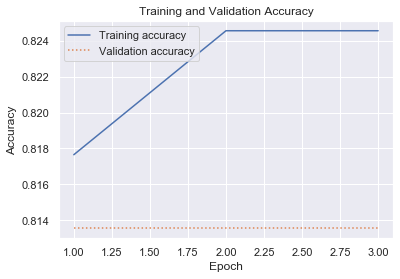

In [44]:
sns.set()
acc = fitting.history['accuracy']
val = fitting.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.plot()